In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torchsummary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
from tqdm import tqdm
from utils_evaluate_model import *

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:2')
elif torch.mps.is_available():
    device = torch.device('mps')
    dtype = torch.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cuda:2


2 variantes, 8 niveaux chacune.


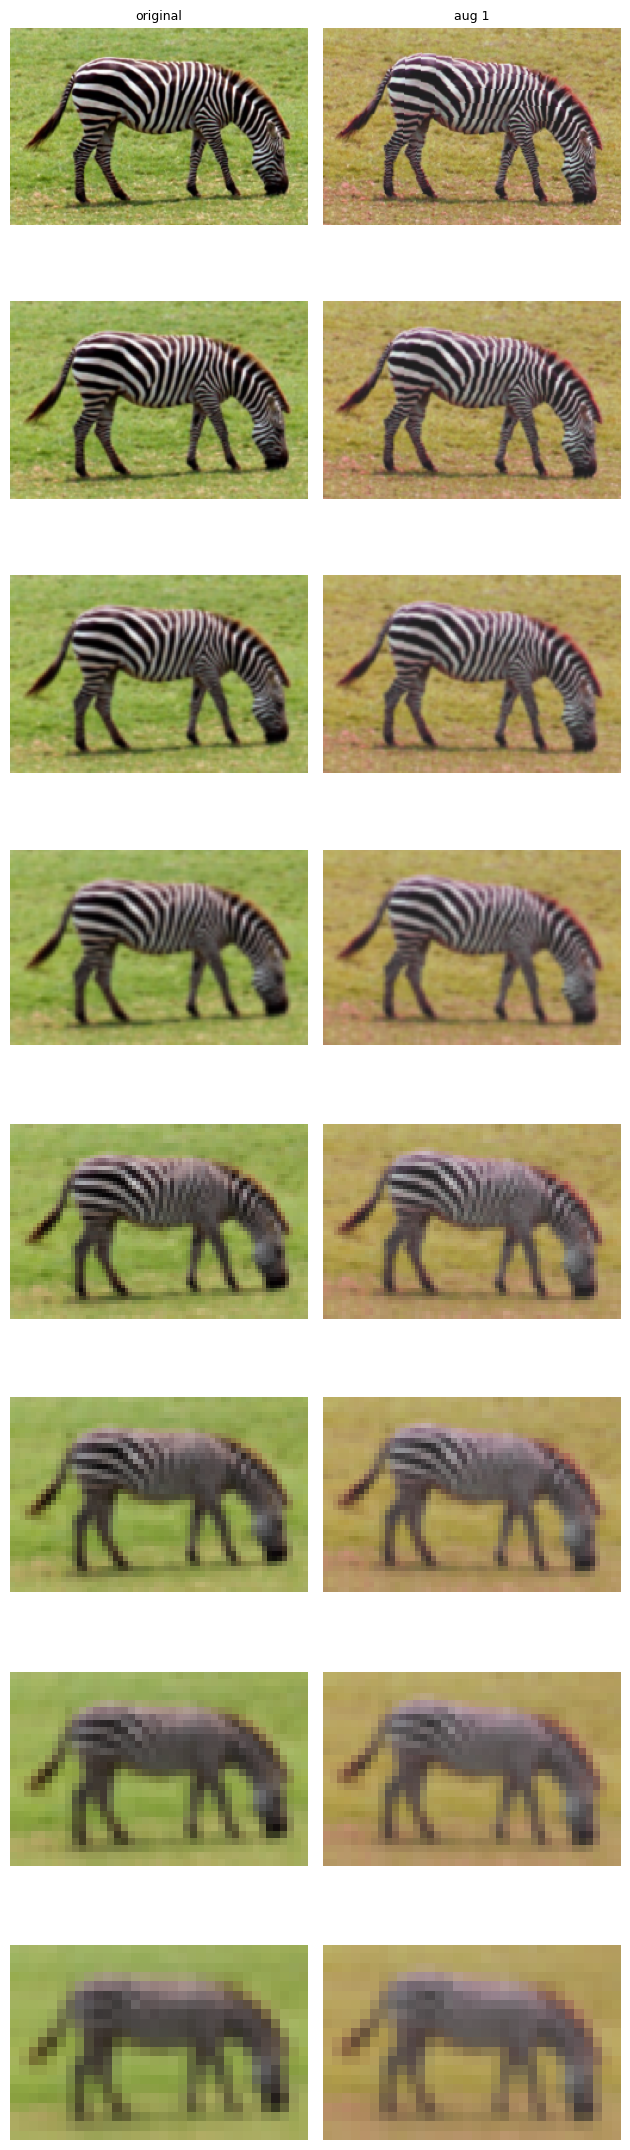

In [3]:
"""
SinGAN data-augmentation helper (torchvision.GaussianBlur)
──────────────────────────────────────────────────────────
• Produit l’image originale + N_AUG variantes aléatoires.
• Augmentations possibles :
      – flips horizontaux / verticaux
      – pad réflectif + rotation aléatoire (sans bordures noires)
      – ColorJitter
      – GaussianBlur (torchvision.transforms.GaussianBlur)
      – bruit gaussien additif
• Chaque variante finit en 3×H×W, valeurs ∈ [-1, 1].
• Construit pour chacune la pyramide d’échelles façon SinGAN.
"""

# ------------------------------------------------------------
# 0. Imports & utils
# ------------------------------------------------------------
import random, torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import resize as tv_resize
from torch.nn.functional import pad as Fpad
import torchvision.transforms as T

# ------------------------------------------------------------
# 1. Config
# ------------------------------------------------------------
IMG_PATH   = Path("images/zebra.png")             # image de référence
MAX_DIM    = 250        # côté le plus long après resize initial
MIN_DIM    = 25         # côté mini à l’échelle la plus coarse
RATIO      = 4 / 3      # facteur de downscale entre niveaux

N_AUG      = 1          # nombre de variantes à générer
MAX_ROT    = 5         # rotation ±MAX_ROT°
PAD_RATIO  = 0.20       # pad(reflect) = PAD_RATIO × taille

JITTER     = dict(brightness=0.25,
                  contrast=0.25,
                  saturation=0.25,
                  hue=0.1)
BLUR_P     = 0.0        # probabilité d’appliquer le flou
BLUR_K     = (3, 5)     # noyaux possibles (entiers impairs)
NOISE_STD  = 0.05       # σ du bruit gaussien (dans [-1,1])

SEED       = 123        # fixer pour reproductibilité

# ------------------------------------------------------------
# 2. Bloc d’augmentation
# ------------------------------------------------------------
class AugmentVariant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.jitter  = T.ColorJitter(**JITTER)
        self.blur_op = [T.GaussianBlur(kernel_size=k, sigma=(0.3, 1.5))
                        for k in BLUR_K]

    @torch.no_grad()
    def forward(self, x):
        # x : 3×H×W ∈ [-1,1]
        C, H, W = x.shape

        # Flips
        # if random.random() < 0.5: x = torch.flip(x, [2])
        # if random.random() < 0.5: x = torch.flip(x, [1])

        # Pad-Rotate-Crop (pas de bordures noires)
        ph, pw = int(H * PAD_RATIO), int(W * PAD_RATIO)
        x = Fpad(x, (pw, pw, ph, ph), mode="reflect")
        angle = random.uniform(-MAX_ROT, MAX_ROT)
        x = TF.rotate(x, angle, expand=False)
        x = TF.center_crop(x, (H, W))

        # ColorJitter
        x = self.jitter((x+1)/2) * 2 - 1

        # GaussianBlur (p = BLUR_P)
        if random.random() < BLUR_P:
            blur = random.choice(self.blur_op)
            x = blur((x+1)/2) * 2 - 1

        # Bruit gaussien additif
        # if NOISE_STD > 0:
        #     x = x + torch.randn_like(x) * NOISE_STD

        return x.clamp(-1, 1)

# ------------------------------------------------------------
# 3. Charger & pré-traiter l’image
# ------------------------------------------------------------
torch.manual_seed(SEED); random.seed(SEED)

img   = Image.open(IMG_PATH).convert("RGB")
orig  = TF.to_tensor(img).to(device)                       # [0,1]
_, H0, W0 = orig.shape
scale = MAX_DIM / max(H0, W0)
orig  = tv_resize(orig, [int(H0*scale), int(W0*scale)], antialias=True)
orig  = orig * 2 - 1                            # [-1,1]

# ------------------------------------------------------------
# 4. Variantes (original + N_AUG)
# ------------------------------------------------------------
augmenter = AugmentVariant().to(device)
variants  = [orig] + [augmenter(orig.clone()) for _ in range(N_AUG)]

# ------------------------------------------------------------
# 5. Pyramides SinGAN
# ------------------------------------------------------------
def build_pyramid(img):
    levels = [img.unsqueeze(0)]              # fine → coarse (déjà sur device)
    while True:
        _, _, h, w = levels[-1].shape
        nh, nw = int(h / RATIO), int(w / RATIO)
        
        down = tv_resize(levels[-1], [nh, nw], antialias=True).to(device)  # <──
        levels.append(down)
        if nh < MIN_DIM or nw < MIN_DIM: break
    return levels

pyramids = [[lvl.to(device) for lvl in build_pyramid(v)] for v in variants]
print(f"{len(variants)} variantes, {len(pyramids[0])} niveaux chacune.")

# ------------------------------------------------------------
# 6. (Optionnel) Visualisation grille
# ------------------------------------------------------------
def show_grid(pyramids):
    rows, cols = len(pyramids[0]), len(pyramids)
    fig, axes  = plt.subplots(rows, cols, figsize=(3.2*cols, 2.8*rows))
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c] if rows > 1 else axes[c]
            img_np = (pyramids[c][r].cpu().squeeze(0).permute(1,2,0)+1)/2
            ax.imshow(img_np.clamp(0,1))
            if r == 0:
                ax.set_title("original" if c == 0 else f"aug {c}", fontsize=9)
            ax.axis('off')
    plt.tight_layout(); plt.show()

# Décommentez pour vérifier visuellement
show_grid(pyramids)


In [4]:
for x in pyramids[1] : 
    print(x.shape)
    print(x.device)

torch.Size([1, 3, 166, 250])
cuda:2
torch.Size([1, 3, 124, 187])
cuda:2
torch.Size([1, 3, 93, 140])
cuda:2
torch.Size([1, 3, 69, 105])
cuda:2
torch.Size([1, 3, 51, 78])
cuda:2
torch.Size([1, 3, 38, 58])
cuda:2
torch.Size([1, 3, 28, 43])
cuda:2
torch.Size([1, 3, 21, 32])
cuda:2


In [5]:
input_size_visu = (3, 1024, 1024)
netG_visu = Generator(n_hidden=32).to("cpu")
torchsummary.summary(netG_visu, input_size=input_size_visu,device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 3, 1024, 1024]             867
             Tanh-14        [-1, 3, 102

In [6]:
netD_visu = Discriminator(n_hidden=32).to("cpu")
torchsummary.summary(netD_visu, input_size=input_size_visu,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 32, 1024, 1024]             896
       BatchNorm2d-2       [-1, 32, 1024, 1024]              64
         LeakyReLU-3       [-1, 32, 1024, 1024]               0
            Conv2d-4       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-5       [-1, 32, 1024, 1024]              64
         LeakyReLU-6       [-1, 32, 1024, 1024]               0
            Conv2d-7       [-1, 32, 1024, 1024]           9,248
       BatchNorm2d-8       [-1, 32, 1024, 1024]              64
         LeakyReLU-9       [-1, 32, 1024, 1024]               0
           Conv2d-10       [-1, 32, 1024, 1024]           9,248
      BatchNorm2d-11       [-1, 32, 1024, 1024]              64
        LeakyReLU-12       [-1, 32, 1024, 1024]               0
           Conv2d-13        [-1, 1, 1024, 1024]             289
Total params: 29,185
Trainable params: 

+ Générations des generateurs/discriminateurs

In [7]:
hidden_lowest_dim = 32
Genarators = []

N = len(pyramids[0])


for i in range(N):
    u = N-i
    Genarators.append(Generator( hidden_lowest_dim *  2**(u//4)).to(device))
   
    

for gen in Genarators : 
     print(gen.n_hidden)



128
64
64
64
64
32
32
32


+ Boucle d'entrainement 

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1 or classname.find('InstanceNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




it scale 7:   0%|          | 0/4000 [00:00<?, ?it/s]

[scale 7 | it 0] 
[scale 7 | it 0]  LR = 5.00e-04

 mean lost 100 iter 1.4039

ratio_loss = 0.1551


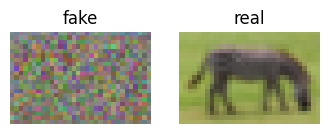

it scale 7:  15%|█▍        | 597/4000 [00:06<00:33, 102.81it/s]

[scale 7 | it 600] 
[scale 7 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0660

ratio_loss = 29.3769


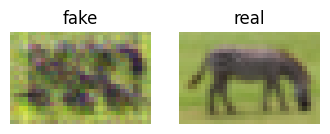

it scale 7:  30%|██▉       | 1196/4000 [00:12<00:35, 78.97it/s]

[scale 7 | it 1200] 
[scale 7 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0639

ratio_loss = 34.8720


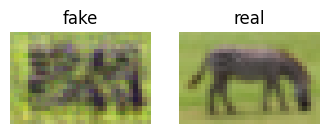

it scale 7:  45%|████▍     | 1796/4000 [00:19<00:24, 88.18it/s] 

[scale 7 | it 1800] 
[scale 7 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0629

ratio_loss = 44.1674


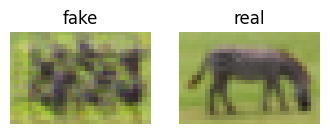

it scale 7:  60%|█████▉    | 2391/4000 [00:26<00:16, 98.52it/s] 

[scale 7 | it 2400] 
[scale 7 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0621

ratio_loss = 38.0621


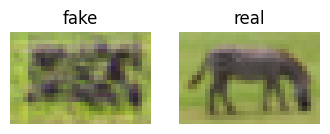

it scale 7:  75%|███████▌  | 3000/4000 [00:32<00:09, 101.29it/s]

[scale 7 | it 3000] 
[scale 7 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0615

ratio_loss = 47.3471


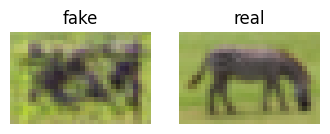

it scale 7:  90%|████████▉ | 3592/4000 [00:38<00:04, 89.08it/s] 

[scale 7 | it 3600] 
[scale 7 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0611

ratio_loss = 36.2099


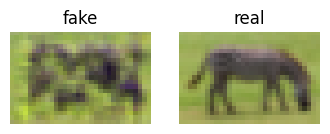

it scale 7: 100%|█████████▉| 3989/4000 [00:42<00:00, 98.41it/s] 

[scale 7 | it 3999] 
[scale 7 | it 3999]  LR = 5.00e-04

 mean lost 100 iter 0.0612

ratio_loss = 49.1328


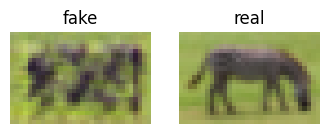

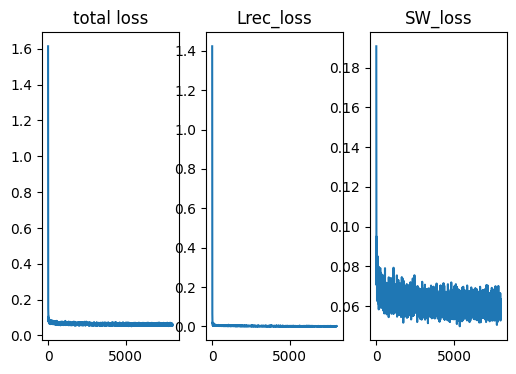

[init] copied weights from scale 7 → 6


it scale 6:   0%|          | 0/4300 [00:00<?, ?it/s]

[scale 6 | it 0] 
[scale 6 | it 0]  LR = 5.00e-04

 mean lost 100 iter 1.2976

ratio_loss = 0.2127


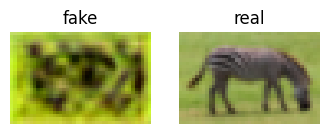

it scale 6:  14%|█▍        | 597/4300 [00:06<00:42, 86.96it/s]

[scale 6 | it 600] 
[scale 6 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0413

ratio_loss = 14.4607


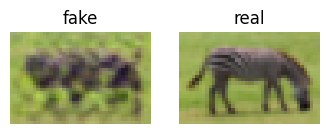

it scale 6:  28%|██▊       | 1199/4300 [00:13<00:33, 92.34it/s]

[scale 6 | it 1200] 
[scale 6 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0397

ratio_loss = 25.3577


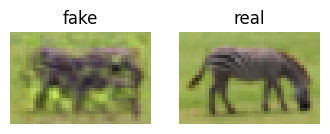

it scale 6:  42%|████▏     | 1798/4300 [00:19<00:26, 93.42it/s]

[scale 6 | it 1800] 
[scale 6 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0388

ratio_loss = 15.6594


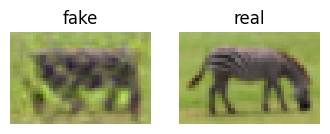

it scale 6:  56%|█████▌    | 2395/4300 [00:26<00:20, 91.93it/s]

[scale 6 | it 2400] 
[scale 6 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0389

ratio_loss = 32.4360


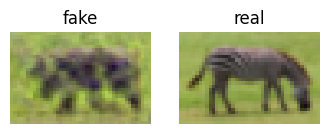

it scale 6:  70%|██████▉   | 2993/4300 [00:33<00:14, 92.60it/s]

[scale 6 | it 3000] 
[scale 6 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0381

ratio_loss = 45.2395


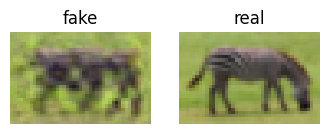

it scale 6:  84%|████████▎ | 3600/4300 [00:39<00:07, 87.54it/s]

[scale 6 | it 3600] 
[scale 6 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0380

ratio_loss = 34.4403


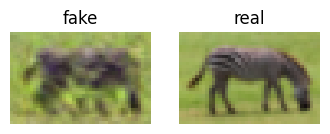

it scale 6:  98%|█████████▊| 4195/4300 [00:46<00:01, 93.43it/s] 

[scale 6 | it 4200] 
[scale 6 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0376

ratio_loss = 28.2178


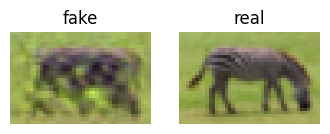

it scale 6: 100%|█████████▉| 4295/4300 [00:47<00:00, 92.75it/s]

[scale 6 | it 4299] 
[scale 6 | it 4299]  LR = 5.00e-04

 mean lost 100 iter 0.0375

ratio_loss = 38.5393


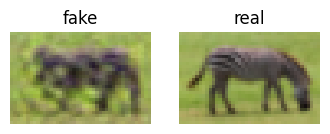

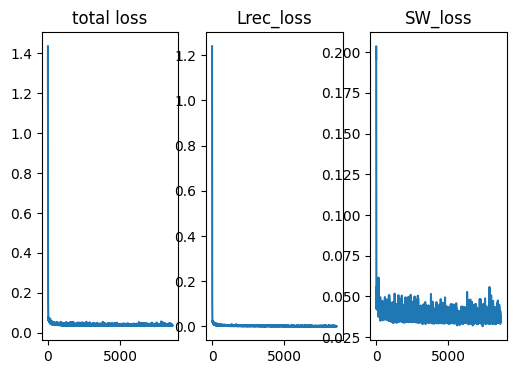

[init] copied weights from scale 6 → 5


it scale 5:   0%|          | 0/4600 [00:00<?, ?it/s]

[scale 5 | it 0] 
[scale 5 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.0665

ratio_loss = 1.0522


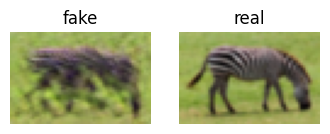

it scale 5:  13%|█▎        | 596/4600 [00:06<00:46, 85.67it/s]

[scale 5 | it 600] 
[scale 5 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0283

ratio_loss = 21.5290


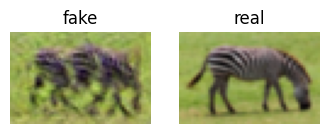

it scale 5:  26%|██▌       | 1199/4600 [00:14<00:39, 86.06it/s]

[scale 5 | it 1200] 
[scale 5 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0281

ratio_loss = 16.5225


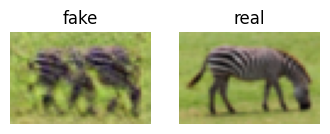

it scale 5:  39%|███▉      | 1793/4600 [00:21<00:32, 86.49it/s]

[scale 5 | it 1800] 
[scale 5 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0278

ratio_loss = 15.9183


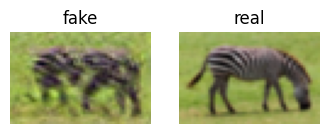

it scale 5:  52%|█████▏    | 2396/4600 [00:28<00:25, 84.80it/s]

[scale 5 | it 2400] 
[scale 5 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0279

ratio_loss = 19.8630


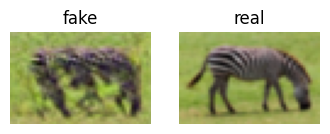

it scale 5:  65%|██████▌   | 2998/4600 [00:35<00:18, 86.54it/s]

[scale 5 | it 3000] 
[scale 5 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0272

ratio_loss = 19.9958


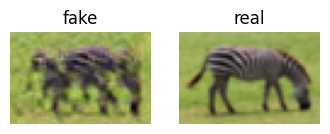

it scale 5:  78%|███████▊  | 3592/4600 [00:42<00:11, 87.05it/s]

[scale 5 | it 3600] 
[scale 5 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0275

ratio_loss = 23.7237


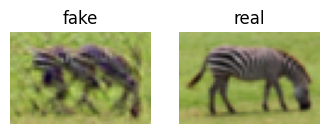

it scale 5:  91%|█████████ | 4193/4600 [00:49<00:04, 87.67it/s]

[scale 5 | it 4200] 
[scale 5 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0267

ratio_loss = 31.8320


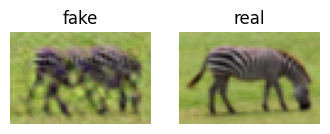

it scale 5: 100%|█████████▉| 4598/4600 [00:54<00:00, 85.41it/s]

[scale 5 | it 4599] 
[scale 5 | it 4599]  LR = 5.00e-04

 mean lost 100 iter 0.0269

ratio_loss = 30.9558


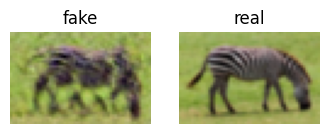

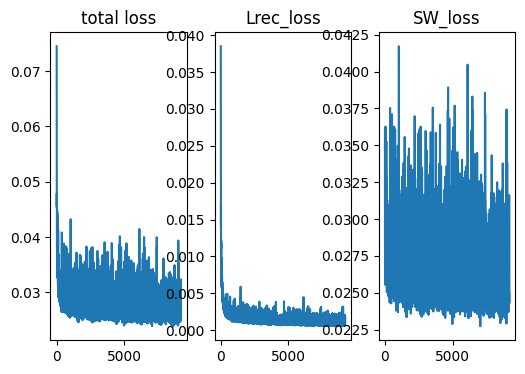

it scale 4:   0%|          | 0/4900 [00:00<?, ?it/s]

[scale 4 | it 0] 
[scale 4 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.9583

ratio_loss = 0.1206


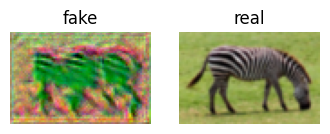

it scale 4:  12%|█▏        | 597/4900 [00:07<00:53, 80.01it/s]

[scale 4 | it 600] 
[scale 4 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0289

ratio_loss = 3.6204


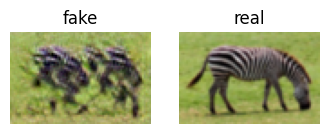

it scale 4:  24%|██▍       | 1199/4900 [00:15<00:45, 80.98it/s]

[scale 4 | it 1200] 
[scale 4 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0254

ratio_loss = 3.6143


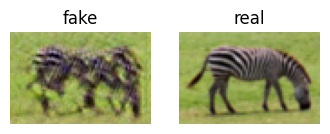

it scale 4:  37%|███▋      | 1795/4900 [00:22<00:38, 80.37it/s]

[scale 4 | it 1800] 
[scale 4 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0251

ratio_loss = 4.9582


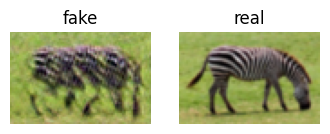

it scale 4:  49%|████▉     | 2394/4900 [00:30<00:31, 80.60it/s]

[scale 4 | it 2400] 
[scale 4 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0239

ratio_loss = 14.1707


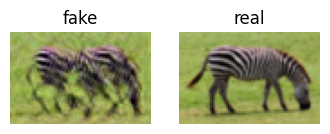

it scale 4:  61%|██████    | 2998/4900 [00:37<00:21, 90.03it/s]

[scale 4 | it 3000] 
[scale 4 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0232

ratio_loss = 9.7820


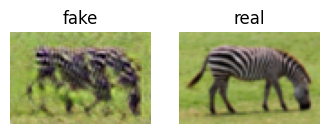

it scale 4:  73%|███████▎  | 3597/4900 [00:44<00:16, 80.87it/s]

[scale 4 | it 3600] 
[scale 4 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0232

ratio_loss = 11.7254


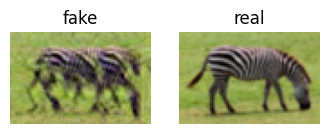

it scale 4:  86%|████████▌ | 4199/4900 [00:52<00:08, 80.81it/s]

[scale 4 | it 4200] 
[scale 4 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0224

ratio_loss = 14.8113


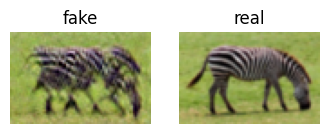

it scale 4:  98%|█████████▊| 4800/4900 [00:59<00:01, 80.03it/s]

[scale 4 | it 4800] 
[scale 4 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.0231

ratio_loss = 14.7143


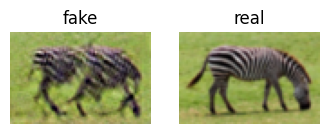

it scale 4: 100%|█████████▉| 4898/4900 [01:01<00:00, 78.38it/s]

[scale 4 | it 4899] 
[scale 4 | it 4899]  LR = 5.00e-04

 mean lost 100 iter 0.0226

ratio_loss = 10.1234


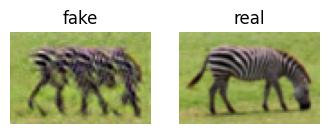

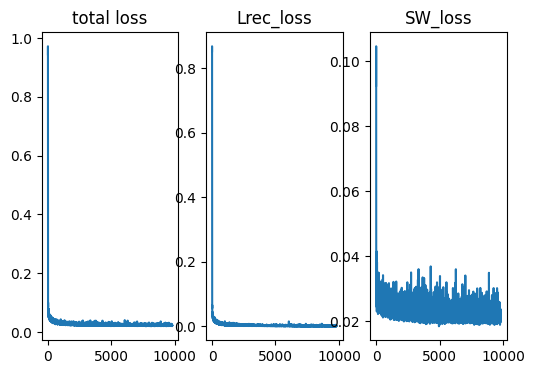

[init] copied weights from scale 4 → 3


it scale 3:   0%|          | 0/5200 [00:00<?, ?it/s]

[scale 3 | it 0] 
[scale 3 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.0495

ratio_loss = 0.8270


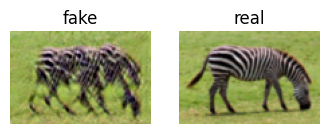

it scale 3:  11%|█▏        | 593/5200 [00:07<01:00, 76.32it/s]

[scale 3 | it 600] 
[scale 3 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0198

ratio_loss = 11.8533


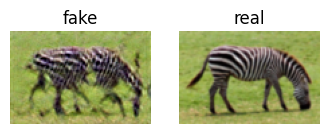

it scale 3:  23%|██▎       | 1197/5200 [00:15<00:47, 84.77it/s]

[scale 3 | it 1200] 
[scale 3 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0188

ratio_loss = 16.4899


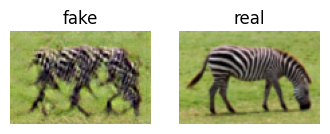

it scale 3:  35%|███▍      | 1799/5200 [00:24<00:45, 74.44it/s]

[scale 3 | it 1800] 
[scale 3 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0192

ratio_loss = 19.2444


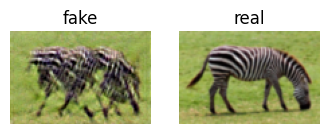

it scale 3:  46%|████▌     | 2398/5200 [00:32<00:37, 74.49it/s]

[scale 3 | it 2400] 
[scale 3 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0193

ratio_loss = 28.5611


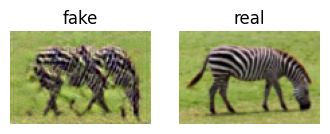

it scale 3:  58%|█████▊    | 2998/5200 [00:40<00:29, 74.24it/s]

[scale 3 | it 3000] 
[scale 3 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0194

ratio_loss = 26.7444


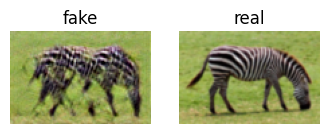

it scale 3:  69%|██████▉   | 3598/5200 [00:48<00:21, 75.84it/s]

[scale 3 | it 3600] 
[scale 3 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0186

ratio_loss = 30.9633


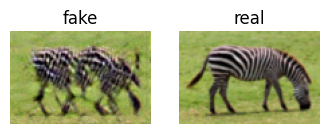

it scale 3:  81%|████████  | 4198/5200 [00:56<00:13, 73.60it/s]

[scale 3 | it 4200] 
[scale 3 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0183

ratio_loss = 28.8538


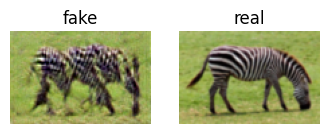

it scale 3:  92%|█████████▏| 4797/5200 [01:04<00:05, 74.74it/s]

[scale 3 | it 4800] 
[scale 3 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.0179

ratio_loss = 16.6034


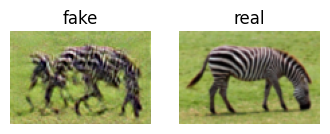

it scale 3: 100%|█████████▉| 5197/5200 [01:10<00:00, 74.83it/s]

[scale 3 | it 5199] 
[scale 3 | it 5199]  LR = 5.00e-04

 mean lost 100 iter 0.0184

ratio_loss = 24.0999


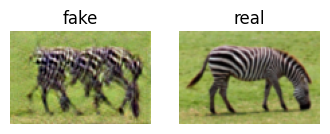

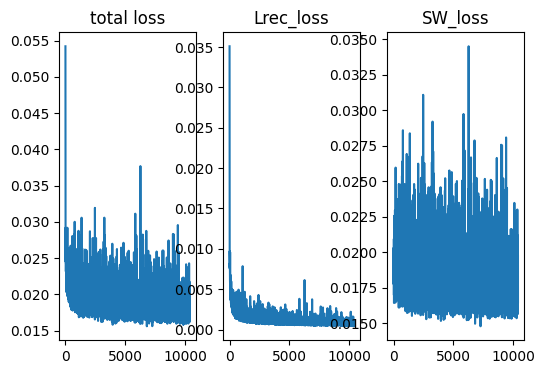

[init] copied weights from scale 3 → 2


it scale 2:   0%|          | 0/5500 [00:00<?, ?it/s]

[scale 2 | it 0] 
[scale 2 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.0424

ratio_loss = 0.8351


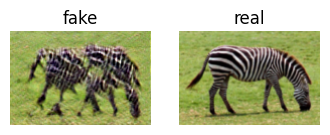

it scale 2:  11%|█         | 600/5500 [00:08<01:10, 69.87it/s]

[scale 2 | it 600] 
[scale 2 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0160

ratio_loss = 7.5138


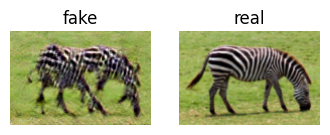

it scale 2:  22%|██▏       | 1200/5500 [00:17<01:03, 67.31it/s]

[scale 2 | it 1200] 
[scale 2 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0156

ratio_loss = 13.4730


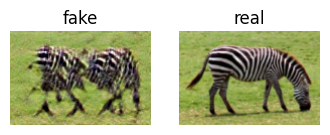

it scale 2:  33%|███▎      | 1800/5500 [00:26<00:53, 69.09it/s]

[scale 2 | it 1800] 
[scale 2 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0161

ratio_loss = 7.7036


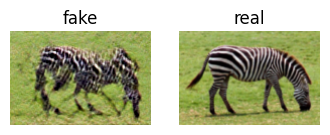

it scale 2:  44%|████▎     | 2400/5500 [00:35<00:44, 69.29it/s]

[scale 2 | it 2400] 
[scale 2 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0158

ratio_loss = 14.5067


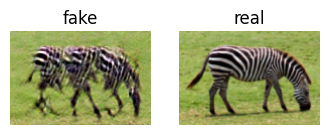

it scale 2:  54%|█████▍    | 2996/5500 [00:43<00:36, 68.74it/s]

[scale 2 | it 3000] 
[scale 2 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0155

ratio_loss = 10.7976


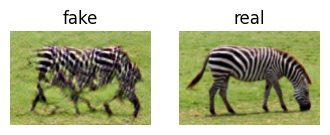

it scale 2:  65%|██████▌   | 3594/5500 [00:53<00:27, 69.79it/s]

[scale 2 | it 3600] 
[scale 2 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0152

ratio_loss = 18.5277


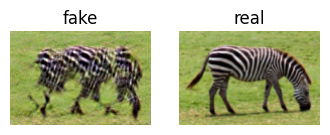

it scale 2:  76%|███████▋  | 4195/5500 [01:02<00:22, 58.99it/s]

[scale 2 | it 4200] 
[scale 2 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0156

ratio_loss = 15.4015


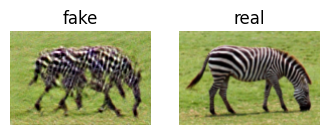

it scale 2:  87%|████████▋ | 4799/5500 [01:12<00:11, 58.95it/s]

[scale 2 | it 4800] 
[scale 2 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.0152

ratio_loss = 18.0693


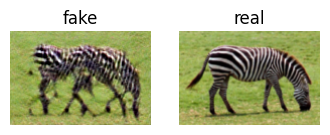

it scale 2:  98%|█████████▊| 5396/5500 [01:21<00:01, 70.55it/s]

[scale 2 | it 5400] 
[scale 2 | it 5400]  LR = 5.00e-04

 mean lost 100 iter 0.0149

ratio_loss = 20.7328


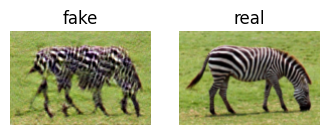

it scale 2: 100%|█████████▉| 5499/5500 [01:22<00:00, 65.66it/s]

[scale 2 | it 5499] 
[scale 2 | it 5499]  LR = 5.00e-04

 mean lost 100 iter 0.0150

ratio_loss = 19.0303


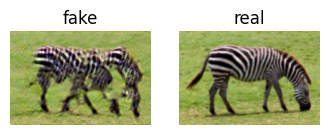

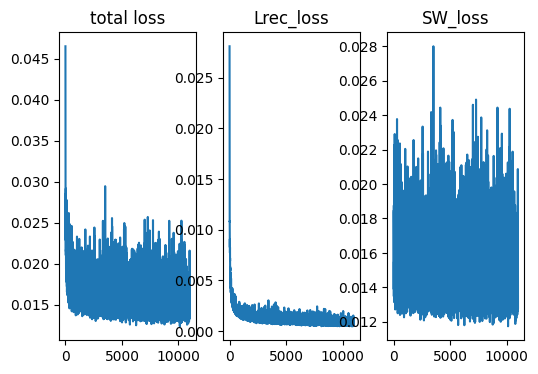

[init] copied weights from scale 2 → 1


it scale 1:   0%|          | 0/5800 [00:00<?, ?it/s]

[scale 1 | it 0] 
[scale 1 | it 0]  LR = 5.00e-04

 mean lost 100 iter 0.0334

ratio_loss = 0.7051


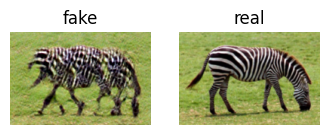

it scale 1:  10%|█         | 600/5800 [00:10<01:22, 62.90it/s]

[scale 1 | it 600] 
[scale 1 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0151

ratio_loss = 5.2437


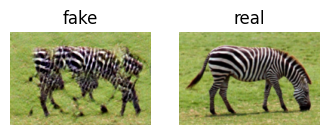

it scale 1:  21%|██        | 1199/5800 [00:20<01:23, 55.05it/s]

[scale 1 | it 1200] 
[scale 1 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0140

ratio_loss = 6.6047


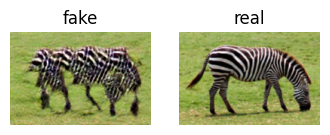

it scale 1:  31%|███       | 1799/5800 [00:30<01:02, 63.58it/s]

[scale 1 | it 1800] 
[scale 1 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0143

ratio_loss = 9.0920


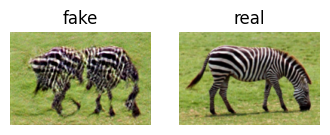

it scale 1:  41%|████▏     | 2396/5800 [00:40<00:57, 59.48it/s]

[scale 1 | it 2400] 
[scale 1 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0145

ratio_loss = 7.6457


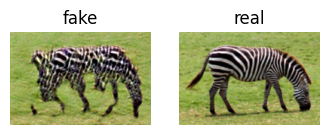

it scale 1:  52%|█████▏    | 2996/5800 [00:50<00:44, 62.88it/s]

[scale 1 | it 3000] 
[scale 1 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0141

ratio_loss = 10.3025


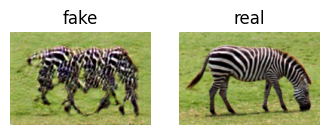

it scale 1:  62%|██████▏   | 3598/5800 [01:00<00:35, 62.50it/s]

[scale 1 | it 3600] 
[scale 1 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0137

ratio_loss = 13.7239


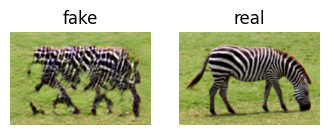

it scale 1:  72%|███████▏  | 4200/5800 [01:09<00:25, 62.73it/s]

[scale 1 | it 4200] 
[scale 1 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0137

ratio_loss = 11.0420


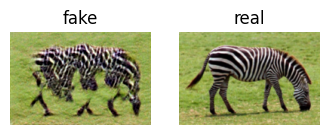

it scale 1:  83%|████████▎ | 4794/5800 [01:19<00:16, 61.77it/s]

[scale 1 | it 4800] 
[scale 1 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.0137

ratio_loss = 11.4042


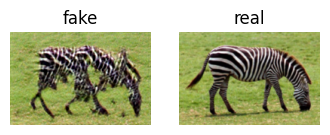

it scale 1:  93%|█████████▎| 5395/5800 [01:28<00:06, 64.51it/s]

[scale 1 | it 5400] 
[scale 1 | it 5400]  LR = 5.00e-04

 mean lost 100 iter 0.0137

ratio_loss = 12.8245


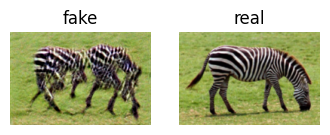

it scale 1: 100%|█████████▉| 5794/5800 [01:35<00:00, 63.48it/s]

[scale 1 | it 5799] 
[scale 1 | it 5799]  LR = 5.00e-04

 mean lost 100 iter 0.0137

ratio_loss = 12.3146


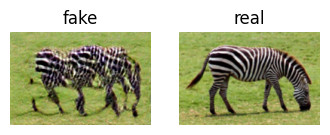

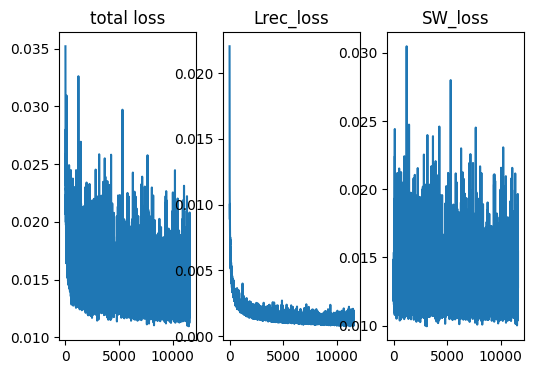

it scale 0:   0%|          | 0/6100 [00:00<?, ?it/s]

[scale 0 | it 0] 
[scale 0 | it 0]  LR = 5.00e-04

 mean lost 100 iter 2.3587

ratio_loss = 0.0947


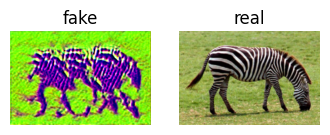

it scale 0:  10%|▉         | 598/6100 [00:23<03:35, 25.56it/s]

[scale 0 | it 600] 
[scale 0 | it 600]  LR = 5.00e-04

 mean lost 100 iter 0.0403

ratio_loss = 0.9269


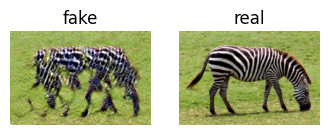

it scale 0:  20%|█▉        | 1198/6100 [00:46<03:11, 25.66it/s]

[scale 0 | it 1200] 
[scale 0 | it 1200]  LR = 5.00e-04

 mean lost 100 iter 0.0276

ratio_loss = 1.1160


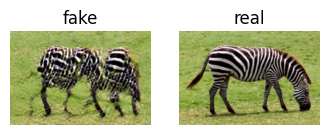

it scale 0:  29%|██▉       | 1798/6100 [01:10<02:47, 25.69it/s]

[scale 0 | it 1800] 
[scale 0 | it 1800]  LR = 5.00e-04

 mean lost 100 iter 0.0214

ratio_loss = 1.5563


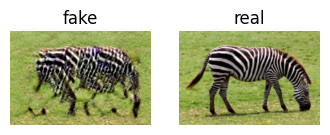

it scale 0:  39%|███▉      | 2398/6100 [01:34<02:23, 25.72it/s]

[scale 0 | it 2400] 
[scale 0 | it 2400]  LR = 5.00e-04

 mean lost 100 iter 0.0278

ratio_loss = 0.8258


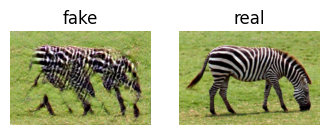

it scale 0:  49%|████▉     | 2998/6100 [01:57<02:00, 25.72it/s]

[scale 0 | it 3000] 
[scale 0 | it 3000]  LR = 5.00e-04

 mean lost 100 iter 0.0205

ratio_loss = 1.2231


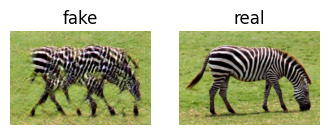

it scale 0:  59%|█████▉    | 3598/6100 [02:21<01:38, 25.42it/s]

[scale 0 | it 3600] 
[scale 0 | it 3600]  LR = 5.00e-04

 mean lost 100 iter 0.0190

ratio_loss = 1.9336


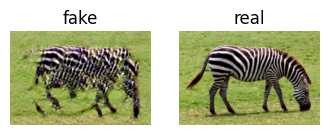

it scale 0:  69%|██████▉   | 4198/6100 [02:44<01:14, 25.54it/s]

[scale 0 | it 4200] 
[scale 0 | it 4200]  LR = 5.00e-04

 mean lost 100 iter 0.0171

ratio_loss = 2.0565


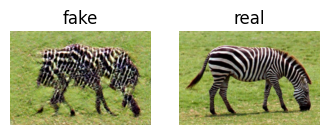

it scale 0:  79%|███████▊  | 4798/6100 [03:08<00:50, 25.61it/s]

[scale 0 | it 4800] 
[scale 0 | it 4800]  LR = 5.00e-04

 mean lost 100 iter 0.0162

ratio_loss = 2.5983


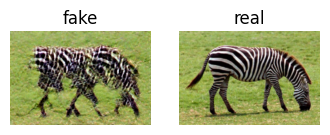

it scale 0:  88%|████████▊ | 5398/6100 [03:31<00:27, 25.67it/s]

[scale 0 | it 5400] 
[scale 0 | it 5400]  LR = 5.00e-04

 mean lost 100 iter 0.0233

ratio_loss = 1.1562


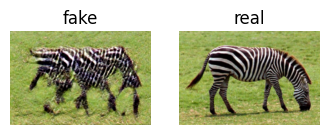

it scale 0:  98%|█████████▊| 5998/6100 [03:55<00:03, 25.67it/s]

[scale 0 | it 6000] 
[scale 0 | it 6000]  LR = 5.00e-04

 mean lost 100 iter 0.0200

ratio_loss = 1.4155


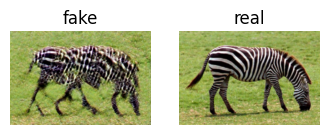

it scale 0: 100%|█████████▉| 6097/6100 [03:58<00:00, 25.61it/s]

[scale 0 | it 6099] 
[scale 0 | it 6099]  LR = 5.00e-04

 mean lost 100 iter 0.0197

ratio_loss = 1.9294


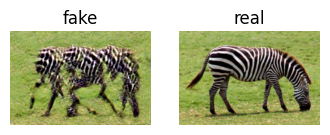

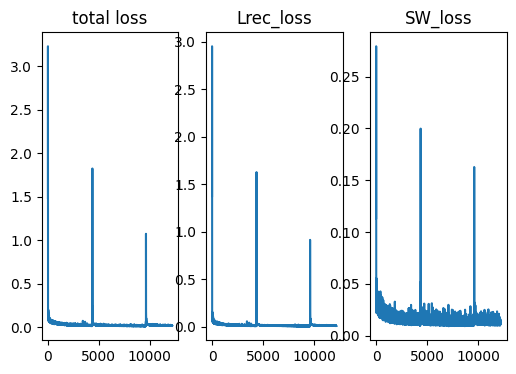

In [10]:
torch.random.manual_seed(1)

# params
lambda_gp    = 10
lr             = 5e-4 # celui du github
betas            = (0.5, 0.999) # pareil
n_Discriminator  = 5 # pif
n_Generator      = 2 # pif
base_iter   = 4000 # github
alpha_rec      = 10 # gith
beta_sigma   = 0.1 # git
debug          = True
b          = 1  # batch size   
lamda_swd = 1

for G in Genarators:
    G.apply(weights_init)


# reset des optim.
optimizer_G = []
for i in range(N):
    optimizer_G.append(optim.Adam(Genarators[i].parameters(), lr=lr, betas=betas))

# --- LR schedulers -----------------------------------------------------------
# Each StepLR will keep the LR unchanged for 1 600 iterations, then multiply it
# by 0.1 once, and keep the new value for the remaining ~400 iterations.
scheduler_G = []

step_size   = 20000        # when to trigger the decay
gamma       = 0.1            # multiplicative factor

for opt_G in optimizer_G:
    scheduler_G.append(
        torch.optim.lr_scheduler.StepLR(opt_G, step_size=step_size, gamma=gamma)
    )

z_star   = torch.randn_like(pyramids[0][-1])               # bruit fixe
sigma_n  = [1.] * N
x_rec    = [None] * N
gen_image = [torch.zeros_like(pyramids[0][-1]).to(device)]
       

@torch.no_grad()
def regenerate_prev_full(k: int, b: int):
    """
    Renvoie prev_img pour l'échelle k (shape = (b, C, Hk, Wk)) :
      • on part d'une image nulle au coarse (N-1) ;
      • on applique tous les G gelés (N-1 … k+1) avec bruit propre à CHAQUE
        élément du batch ;
      • on upsample à la résolution k.
    """
    # ----------- 0. raccourci coarse ---------------------------------------
    if k == N - 1:                       # échelle la plus grossière
        _, C, Hc, Wc = pyramids[0][k].shape   # scales[k] == (1,C,H,W)
        return torch.zeros(b, C, Hc, Wc, device=device)

    # ----------- 1. point de départ (N-1) ----------------------------------
    _, C, Hc, Wc = pyramids[0][-1].shape
    img = torch.zeros(b, C, Hc, Wc, device=device)        # (b,C,Hc,Wc)

    z  = torch.randn_like(img) * sigma_n[N - 1]
    img = Genarators[N - 1](z)                            # (b,C,Hc,Wc)

    # ----------- 2. remontée N-2 … k+1 -------------------------------------
    for s in range(N - 2, k, -1):
        _, _, Hs, Ws = pyramids[0][s].shape

        # upsample vers la taille courante s
        img_up = F.interpolate(img, size=(Hs, Ws),
                               mode='bilinear', align_corners=False)

        # bruit propre à chaque élément du batch
        z = torch.randn_like(img_up) * sigma_n[s]

        # passage résiduel : G_s(z + img_up) + img_up
        img = Genarators[s](z + img_up) + img_up

    # ----------- 3. dernier upsample vers l'échelle k ----------------------
    _, _, Hk, Wk = pyramids[0][k].shape
    prev_img = F.interpolate(img, size=(Hk, Wk),
                             mode='bilinear', align_corners=False)
    return prev_img 


# trainning toutes les scales
for n in range(N):
    current_res  = N - n - 1          
    Gk = Genarators[current_res].train()
    xk_real = pyramids[0][current_res].to(device)
    
    
    if current_res < N-1:                          
        G_prev = Genarators[current_res + 1]

        def same_channels(net_a, net_b):
            """return True if first conv out-channels match"""
            for m_a, m_b in zip(net_a.modules(), net_b.modules()):
                if isinstance(m_a, torch.nn.Conv2d):
                    return m_a.out_channels == m_b.out_channels
            return False

        if same_channels(Gk, G_prev):              
            Gk.load_state_dict(G_prev.state_dict(), strict=True)
            if debug:
                print(f"[init] copied weights from scale {current_res+1} → {current_res}")

    # NB: from here on, use *Gk* / *Dk*; they already sit in the
    #     Genarators / Discriminators lists, so nothing else changes.
    Gk.train()
    # (re-attach the optimisers in case parameters were just overwritten)
    opt_G = optimizer_G[current_res]
    

# Calcul ecart type nécessaire pour le bruit.
    if current_res < N-1:
        up_rec = F.interpolate(x_rec[current_res+1],
                               size=xk_real.shape[2:], mode='bilinear', align_corners=False)

        # σ_n = β · RMSE((x_rec[n+1]↑), x_n) / RMSE(0, x_n) # formule trouvé je sais plus ou. 
        num   = F.mse_loss(up_rec, xk_real)             
        denom = F.mse_loss(torch.zeros_like(xk_real), xk_real)
        sigma_n[current_res] = beta_sigma * torch.sqrt(num / denom)   
    else:
        sigma_n[current_res] = torch.tensor(1, device=device)
    total_loss_list = []
    Lrec_loss_list = []
    Sw_loss_list = []
    # itérations par scale
    iter_per_scale = base_iter+ 300*n
    
    for it in tqdm(range(iter_per_scale), desc=f"it scale {current_res}", leave=False):
        idx = torch.randint(0, 1, (b,))
        xk_real = torch.stack([pyramids[i][current_res].squeeze(0) for i in idx]).to(device)
        # prev_img tiré fraichement
        with torch.no_grad():
            prev_img = regenerate_prev_full(current_res,b)


        for g_idx in range(n_Generator):
            opt_G.zero_grad()
            z = torch.randn_like(prev_img) * sigma_n[current_res]
            fake = Gk(z + prev_img) + prev_img
            patch_size = 11
            stride = 3
            real_patches_flat = extract_patches_batched(xk_real, patch_size, stride)
            fake_patches_flat = extract_patches_batched(fake, patch_size, stride)

            # Calculate the Sliced Wasserstein Distance
            swd = sliced_wasserstein_distance(real_patches_flat, fake_patches_flat, num_projections=128)
            # ----- Reconstruction eq. 5 -----
            if current_res == N-1:                         # coarse
                rec_in = z_star.repeat(b,1,1,1)                             # MOD (z_star)
                rec_out = Gk(rec_in)                       # pas de upsample
            else:                                          # n < N
                up_fixed = F.interpolate(x_rec[current_res+1],
                                          size=xk_real.shape[2:], mode='bilinear', align_corners=False)
                up_fixed = up_fixed.repeat(b,1,1,1)
                rec_in = up_fixed                          # MOD (bruit = 0)
                rec_out = Gk(rec_in) + up_fixed            # MOD

            Lrec_loss = alpha_rec * F.mse_loss(rec_out, xk_real)
            Sw_loss = lamda_swd*swd
            total_loss = Lrec_loss + Sw_loss
            (total_loss).backward()
            total_loss_list.append(total_loss.item())
            Lrec_loss_list.append(Lrec_loss.item())
            Sw_loss_list.append(Sw_loss.item())
            opt_G.step()
        
        # ---- advance LR scheduler *once* for this outer iteration
        scheduler_G[current_res].step()
        
        # logs
        if debug and (it % 600 == 0 or it==iter_per_scale-1):
            ratio_loss = abs(Sw_loss.item())/(abs(Lrec_loss.item()) + 1e-8)

            # pas de torch.no_grad() ici : on a besoin du backward dans lipconstant
            print(f"[scale {current_res} | it {it}] ")
            current_lr = opt_G.param_groups[0]['lr']
            print(f"[scale {current_res} | it {it}]  LR = {current_lr:.2e}")
            print(f'\n mean lost 100 iter {np.mean(total_loss_list[-100:]):.4f}')
            print(f"\nratio_loss = {ratio_loss:.4f}")
            
        

            with torch.no_grad():                     # on garde no_grad pour l’affichage
                plt.figure(figsize=(4,2))
                plt.subplot(1,2,1); plt.imshow(pil_from_minus1to1(fake[0].cpu())); plt.axis('off'); plt.title('fake')
                plt.subplot(1,2,2); plt.imshow(pil_from_minus1to1(xk_real[0].cpu()));        plt.axis('off'); plt.title('real')
                plt.show()
    # fige G_k et stocke fake pour l’échelle au-dessus 
    with torch.no_grad():
        gen_image.append(fake[0].detach())
        if current_res == N-1:
            x_rec[current_res] = Gk(z_star)                              # NEW (bruit fixe)
        else:
            up_rec_k = F.interpolate(x_rec[current_res+1], size=xk_real.shape[2:], mode='bilinear', align_corners=False)
            x_rec[current_res] = Gk(up_rec_k) + up_rec_k                 # NEW (bruit 0)
        Gk.eval()
        for p in Gk.parameters(): 
            p.requires_grad_(False)
    plt.figure(figsize=(6,4))
    
    plt.subplot(1,3,1)
    plt.plot(total_loss_list)
    plt.title("total loss")
    plt.subplot(1,3,2)
    plt.plot(Lrec_loss_list)
    plt.title("Lrec_loss")
    plt.subplot(1,3,3)
    plt.plot(Sw_loss_list)
    plt.title("SW_loss")
    
    plt.show()

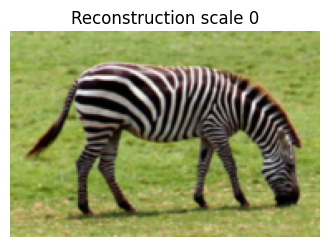

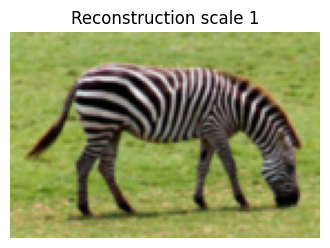

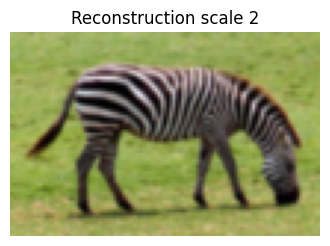

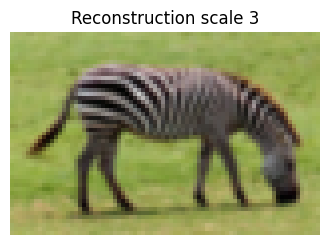

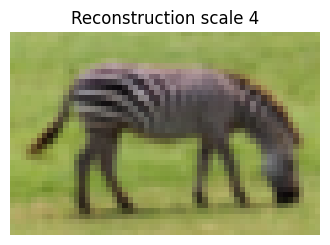

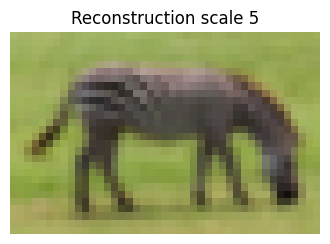

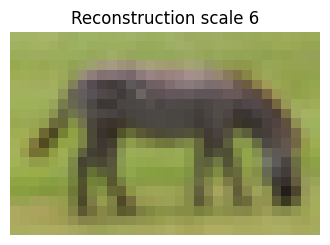

In [12]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_reconstructions(x_rec):
    for i, rec in enumerate(x_rec):
        if rec is None:
            continue
        img = rec.detach().cpu().squeeze()
        plt.figure(figsize=(4,4))
        plt.title(f"Reconstruction scale {i}")
        plt.imshow(pil_from_minus1to1(img))
        plt.axis('off')
        plt.show()

plot_reconstructions(x_rec[1:])

SAVING GENERATORS AND NECESSARY PARAMS

In [13]:
# ==== SAVE GENERATORS ========================================================
import os, datetime, torch, json

model_name = "sw" 
image_name = "zebre"                   
model_dir  = os.path.join("models", image_name,model_name)
weights_fp = os.path.join(model_dir, "generators.pt")
descr_fp   = os.path.join(model_dir, "Description.txt")
sigma_fp   = os.path.join(model_dir, "sigma_n.json")
zstar_fp   = os.path.join(model_dir, "z_star.pt")    # ← chemin pour z_star

if os.path.exists(model_dir):
    print(f"ATTENTION : Un modèle nommé '{model_name}' existe déjà dans '{model_dir}'.")
    print("   → Choisis un autre nom pour ne pas l'écraser.")
else:
    os.makedirs(model_dir, exist_ok=True)

    # 1) sauvegarde des poids : liste d'état (un par G_k)
    torch.save([G.state_dict() for G in Genarators], weights_fp)

    # 2) petit fichier description (texte lisible)
    description = {
        "date"           : datetime.datetime.now().isoformat(timespec="seconds"),
        "N"              : N,
        "r"                 : float(4/3),
        "lr"             : lr,
        "betas"          : betas,
        "patch_size": 11,
        "n_Generator"    : n_Generator,
        "base_iter" : base_iter,
        "alpha_rec"      : alpha_rec,
        "beta_sigma"     : beta_sigma,
        "lambda_sw" : lamda_swd,
        "stride" : 3,
        "comment"        : "Sin Gan avec de la data aug sur l'image réele. + swd reg",
    }
    with open(descr_fp, "w", encoding="utf-8") as f:
        for k, v in description.items():
            f.write(f"{k}: {v}\n")

    # 3) sauvegarde de la liste sigma_n
    sigma_list = []
    for s in sigma_n:
        # si s est un tensor scalaire, on fait s.item(), sinon on lève une erreur
        if torch.is_tensor(s):
            sigma_list.append(s.item())
        else:
            sigma_list.append(float(s))
    with open(sigma_fp, "w", encoding="utf-8") as f:
        json.dump(sigma_list, f)


    # 4) génération et sauvegarde de z_star
    #    remplace (h, w) par la forme souhaitée
    torch.save(z_star, zstar_fp)

    print(f"Générateurs sauvegardés     -> {weights_fp}")
    print(f"Description créée           -> {descr_fp}")
    print(f"sigma_n sauvegardé          -> {sigma_fp}")
    print(f"z_star sauvegardé           -> {zstar_fp}")


Générateurs sauvegardés     -> models/zebre/sw/generators.pt
Description créée           -> models/zebre/sw/Description.txt
sigma_n sauvegardé          -> models/zebre/sw/sigma_n.json
z_star sauvegardé           -> models/zebre/sw/z_star.pt
